# Video to video with gpt-4o and Sora

Sora is an AI model from OpenAI that can create realistic and imaginative video scenes from text instructions. The model is capable of generating a wide range of video content, including realistic scenes, animations, and special effects. Several video resolutions and durations are supported.

https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/video-generation

In [1]:
import base64
import cv2
import datetime
import glob
import matplotlib.pyplot as plt
import openai
import os
import requests
import sys
import time

from dotenv import load_dotenv
from io import BytesIO
from IPython.display import Video, FileLink
from moviepy import *
from mimetypes import guess_type
from openai import AzureOpenAI

In [2]:
sys.version

'3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]'

In [3]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 02-Jun-2025 11:19:12


## Settings

In [4]:
load_dotenv("azure.env")

endpoint = os.environ['AZURE_OPENAI_ENDPOINT']
api_key = os.environ['AZURE_OPENAI_API_KEY']

api_version = "2025-04-01-preview"
model = "gpt-4o"
sora_model = "sora"

In [5]:
VIDEO_DIR = "inputvideos"

In [6]:
OUTPUT_DIR = "videos"

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [7]:
FRAMES_DIR = "frames"

os.makedirs(FRAMES_DIR, exist_ok=True)

## Helper

In [8]:
def get_frames(video_path, fps=1):
    """
    Extracts frames from a video at a specified frame rate and saves them as image files.

    Parameters:
    video_path (str): Path to the input video file.
    output_folder (str): Directory where the extracted frames will be saved.
    fps (int, optional): Number of frames to extract per second of video. Default is 1.

    The function creates the output folder if it does not exist, reads the video file, and extracts frames at the specified rate. 
    Each extracted frame is saved as a JPEG image in the output folder with a filename in the format 'frame_XXXXX.jpg'.
    """
    print(f"Extracting frames from the video {video_path}...")

    video = cv2.VideoCapture(video_path)
    original_fps = int(video.get(cv2.CAP_PROP_FPS))
    frame_interval = int(original_fps / fps)
    frame_count = 0
    saved_count = 0

    while True:
        ret, frame = video.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            filename = os.path.join(FRAMES_DIR, f"frame_{saved_count+1:06d}.jpg")
            cv2.imwrite(filename, frame)
            saved_count += 1

        frame_count += 1

    video.release()
    print(f"Done. Number of extracted frames = {saved_count}")

In [9]:
def local_image_to_data_url(image_path):
    """
    Converts a local image file to a data URL.

    Parameters:
    image_path (str): Path to the local image file.

    Returns:
    str: A data URL containing the base64-encoded image data.
    """
    mime_type, _ = guess_type(image_path)

    if mime_type is None:
        mime_type = "application/octet-stream"

    with open(image_path, "rb") as image_file:
        base64_encoded_data = base64.b64encode(image_file.read()).decode("utf-8")

    return f"data:{mime_type};base64,{base64_encoded_data}"

In [10]:
def describe_frame_with_gpt4o(image_file, prompt):
    """
    Uses GPT-4o to analyze an image frame from a video based on a given prompt.

    Parameters:
    image_file (str): Path to the image file to be analyzed.
    prompt (str): Text prompt describing what to analyze in the image.

    Returns:
    str: The description generated by GPT-4o based on the image and prompt.

    The function initializes an AzureOpenAI client, sends a request to the GPT-4o model with the image and prompt, 
    and returns the generated description. The image is converted to a data URL before being sent to the model.
    """
    client = AzureOpenAI(
        api_key=api_key,
        api_version=api_version,
        base_url=f"{endpoint}/openai/deployments/{model}",
    )

    response = client.chat.completions.create(
        model=model,
        messages=[
            {
                "role":
                "system",
                "content":
                "You are an AI helpful assistant to analyse image frame from a video.",
            },
            {
                "role":
                "user",
                "content": [
                    {
                        "type": "text",
                        "text": prompt
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": local_image_to_data_url(image_file)
                        },
                    },
                ],
            },
        ],
        max_tokens=2000,
        temperature=0.7,
    )

    return response.choices[0].message.content

In [11]:
def sora(prompt, width=480, height=480, n_seconds=5):
    """
    Generates a video based on the given prompt using the SORA model.

    Parameters:
    prompt (str): The text prompt to generate the video.
    width (int): The width of the video. Supported values are 480, 854, 720, 1080, and 1920.
    height (int): The height of the video. Supported values are 480, 854, 720, 1080, and 1920.
    n_seconds (int): The duration of the video in seconds. Must be between 1 and 20 seconds.
    n_variants (int): The number of video variants to generate.
    
    Returns:
    str: The filename of the generated video.

    Raises:
    Exception: If the video generation job fails or no generations are found.
    """
    start = time.time()

    api_version = 'preview'
    headers = {"api-key": api_key, "Content-Type": "application/json"}

    idx = datetime.datetime.today().strftime('%d%b%Y_%H%M%S')
    output_filename = os.path.join(OUTPUT_DIR, f"sora_{idx}.mp4")

    # 1. Create a video generation job
    create_url = f"{endpoint}/openai/v1/video/generations/jobs?api-version={api_version}"
    body = {
        "prompt": prompt,
        "width":
        width,  # 480x480, 480x854, 854x480, 720x720, 720x1280, 1280x720, 1080x1080, 1080x1920, 1920x1080.
        "height":
        height,  # 480x480, 480x854, 854x480, 720x720, 720x1280, 1280x720, 1080x1080, 1080x1920, 1920x1080.
        "n_seconds": n_seconds,  # between 1 and 20 seconds
        "model": sora_model,  # SORA model
    }
    response = requests.post(create_url, headers=headers, json=body)
    response.raise_for_status()

    now = datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')
    print(f"{now} Full response JSON:", response.json())
    print()

    job_id = response.json()["id"]
    now = datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')
    print(f"{now} Job created: {job_id}")

    # 2. Poll for job status
    status_url = f"{endpoint}/openai/v1/video/generations/jobs/{job_id}?api-version={api_version}"
    status = None

    while status not in ("succeeded", "failed", "cancelled"):
        time.sleep(5)  # Wait before polling again
        status_response = requests.get(status_url, headers=headers).json()
        status = status_response.get("status")
        now = datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')
        print(f"{now} Job status: {status}")

    # 3. Retrieve generated video
    if status == "succeeded":
        generations = status_response.get("generations", [])

        if generations:
            now = datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')
            print(f"\n{now} ✅ Done. Video generation succeeded.")
            generation_id = generations[0].get("id")
            video_url = f"{endpoint}/openai/v1/video/generations/{generation_id}/content/video?api-version={api_version}"
            video_response = requests.get(video_url, headers=headers)

            if video_response.ok:
                # Downloading the video
                with open(output_filename, "wb") as file:
                    file.write(video_response.content)
                    print(f"\nSORA Generated video saved: '{output_filename}'")

                elapsed = time.time() - start
                minutes, seconds = divmod(elapsed, 60)
                print(f"Done in {minutes:.0f} minutes and {seconds:.0f} seconds")

                return output_filename
        else:
            raise Exception("Error. No generations found in job result.")
    else:
        raise Exception(f"Error. Job did not succeed. Status: {status}")

In [12]:
def view_images(images_list, num_cols=3):
    """
    Displays multiple images in a grid layout.

    Parameters:
    images_list (list): List of paths to the image files to be displayed.
    num_cols (int, optional): Number of columns in the grid. Default is 3.

    The function calculates the number of rows needed based on the number of images and the specified number of columns.
    It then creates a matplotlib figure with subplots arranged in a grid. Each image is read and displayed in its respective subplot.
    Any remaining subplots (if the number of images is not a perfect multiple of num_cols) are turned off.
    """
    num_rows = int(len(images_list) / num_cols) + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 12))

    for idx, ax in enumerate(axes.flat):
        if idx < len(images_list):
            image = plt.imread(images_list[idx])
            ax.imshow(image)
            ax.axis('off')

        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

## Example

### Input video file

In [13]:
input_video_file = os.path.join(VIDEO_DIR, "video.mp4")

Video(input_video_file, width=860)

In [14]:
video_link = FileLink(path=input_video_file)
video_link

/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow8/code/Users/seretkow/SORA/inputvideos/video.mp4

### Get frames extraction

In [15]:
# Get frames
get_frames(input_video_file, fps=1)

Extracting frames from the video inputvideos/video.mp4...
Done. Number of extracted frames = 5


In [16]:
!ls $FRAMES_DIR -lh

total 464K
-rwxrwxrwx 1 root root 89K Jun  2 11:19 frame_000001.jpg
-rwxrwxrwx 1 root root 95K Jun  2 11:19 frame_000002.jpg
-rwxrwxrwx 1 root root 93K Jun  2 11:19 frame_000003.jpg
-rwxrwxrwx 1 root root 97K Jun  2 11:19 frame_000004.jpg
-rwxrwxrwx 1 root root 91K Jun  2 11:19 frame_000005.jpg


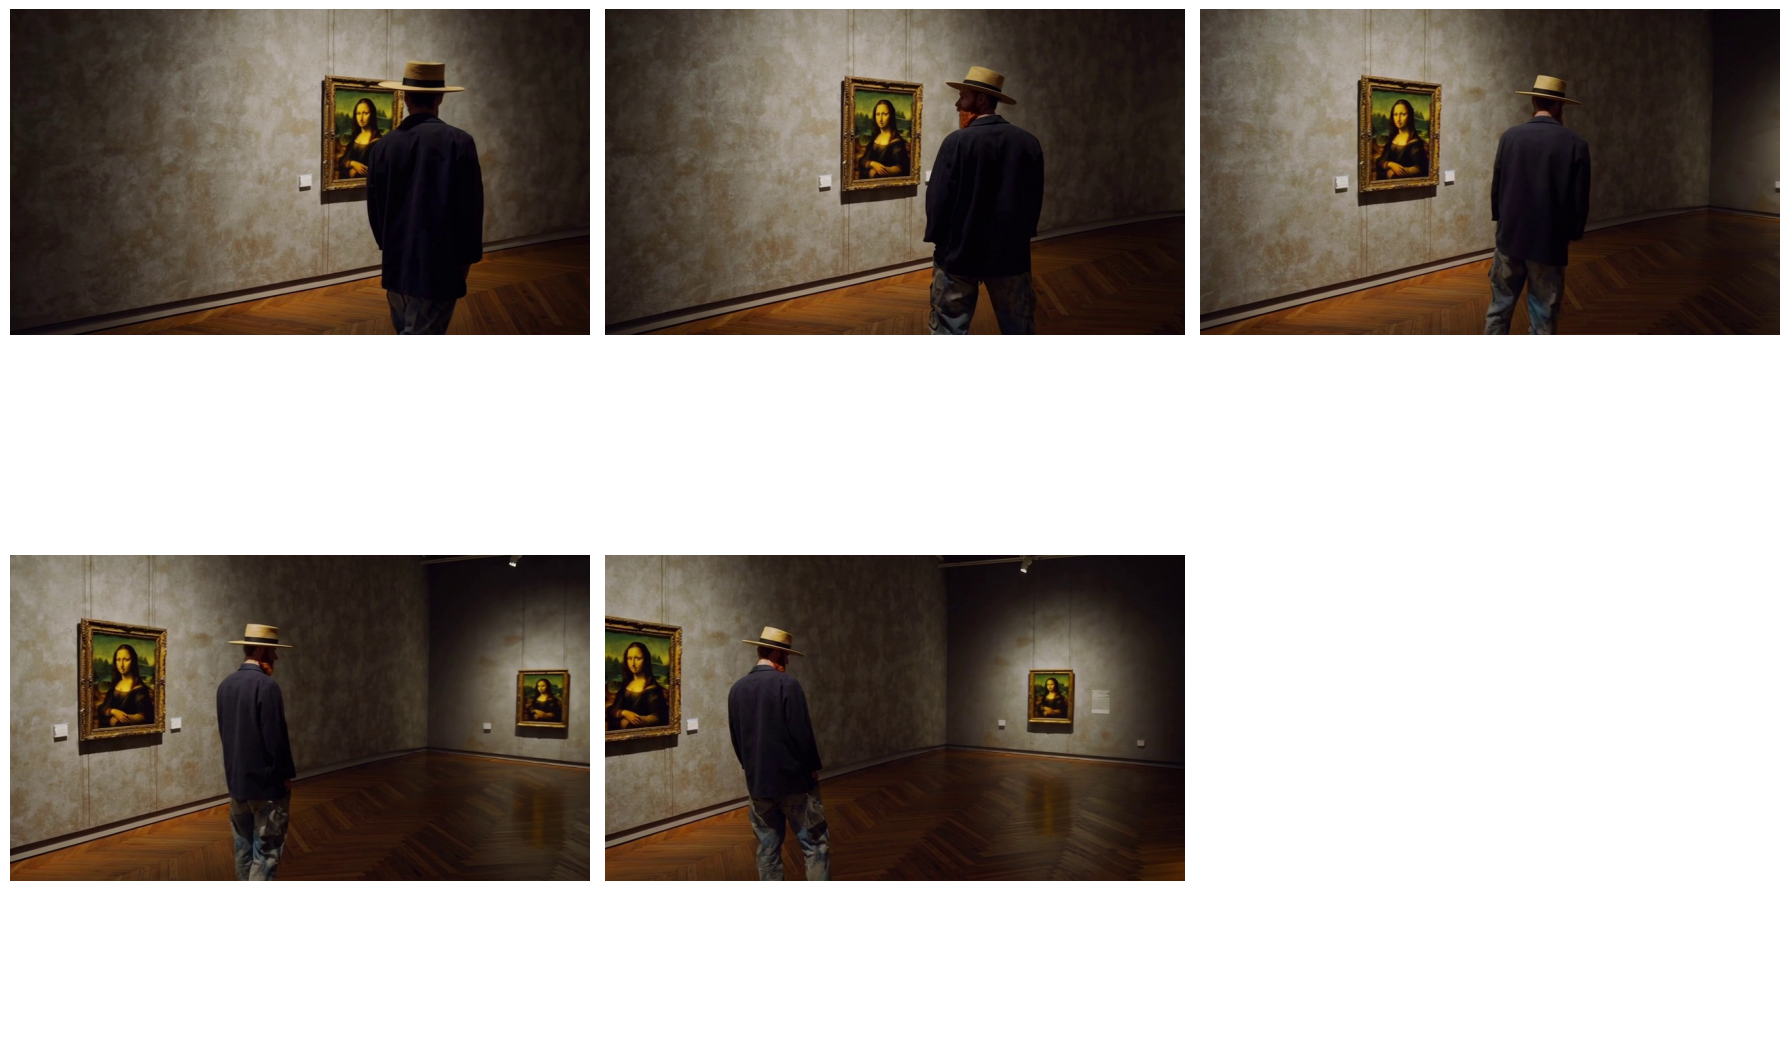

In [17]:
images_list = glob.glob(FRAMES_DIR + "/*.jpg")
view_images(images_list, num_cols=3)

### Frames analysis

In [18]:
# Describe all frames
description_list = []

for frame_file in sorted(os.listdir(FRAMES_DIR)):
    if frame_file.lower().endswith(".jpg"):
        image_file = os.path.join(FRAMES_DIR, frame_file)
        print("Analyzing frame:", image_file)
        result = describe_frame_with_gpt4o(
            image_file,
            "Describe the following image in detail, including the main objects, their colors, positions, motions and any notable features"
        )
        description_list.append(result)

print("Done")

Analyzing frame: frames/frame_000001.jpg
Analyzing frame: frames/frame_000002.jpg
Analyzing frame: frames/frame_000003.jpg
Analyzing frame: frames/frame_000004.jpg
Analyzing frame: frames/frame_000005.jpg
Done


### SORA model

In [19]:
descriptions = "\n".join([f"Video frame description for timerange {idx}: {desc}\n" for idx, desc in enumerate(description_list, start=1)])

In [20]:
sora_prompt = f"Based on the following descriptions of each frame per second of a video:\n {descriptions} \nPlease create a coherent generative AI prompt that can be used to generate a video."

In [21]:
print(sora_prompt)

Based on the following descriptions of each frame per second of a video:
 Video frame description for timerange 1: The image depicts the interior of an art gallery or museum with a focus on a framed painting mounted on a textured beige wall. The painting features a gold ornate frame and is positioned slightly to the right of the center of the image. Below the painting is a small white placard, likely containing its description or title. The floor consists of polished wooden planks arranged in a herringbone pattern, adding a warm tone to the setting.

In the foreground, a person wearing a wide-brimmed straw hat and a dark navy or black coat is standing and facing the painting. The person is positioned slightly to the right, partially obscuring the painting. Their stance indicates they are observing the artwork. The overall lighting is soft and warm, creating a calm and contemplative atmosphere suitable for a museum or gallery environment.

Video frame description for timerange 2: The im

In [22]:
generated_video_file = sora(sora_prompt, width=854, height=480, n_seconds=5)

02-Jun-2025 11:20:34 Full response JSON: {'object': 'video.generation.job', 'id': 'task_01jwr5ycp8evjv89p6y1w17e9t', 'status': 'queued', 'created_at': 1748863234, 'finished_at': None, 'expires_at': None, 'generations': [], 'prompt': 'Based on the following descriptions of each frame per second of a video:\n Video frame description for timerange 1: The image depicts the interior of an art gallery or museum with a focus on a framed painting mounted on a textured beige wall. The painting features a gold ornate frame and is positioned slightly to the right of the center of the image. Below the painting is a small white placard, likely containing its description or title. The floor consists of polished wooden planks arranged in a herringbone pattern, adding a warm tone to the setting.\n\nIn the foreground, a person wearing a wide-brimmed straw hat and a dark navy or black coat is standing and facing the painting. The person is positioned slightly to the right, partially obscuring the painti

In [23]:
!ls $generated_video_file -lh

-rwxrwxrwx 1 root root 3.5M Jun  2 11:21 videos/sora_02Jun2025_112034.mp4


In [24]:
Video(generated_video_file, width=860)

In [25]:
video_link = FileLink(path=generated_video_file)
video_link

/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow8/code/Users/seretkow/SORA/videos/sora_02Jun2025_112034.mp4

## Initial video and generated video

In [26]:
# Combining the two videos
both_videos = os.path.join(OUTPUT_DIR, "video_to_video_sidebyside.mp4")

clip1 = VideoFileClip(input_video_file)
clip2 = VideoFileClip(generated_video_file)
both_clips = clips_array([[clip1, clip2]])
both_clips.write_videofile(both_videos, codec="libx264", audio_codec="aac")

{'video_found': True, 'audio_found': False, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf60.16.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [854, 480], 'bitrate': 6293, 'fps': 30.0, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]', 'encoder': 'Lavc60.31.102 libx264'}}], 'input_number': 0}], 'duration': 5.0, 'bitrate': 6298, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(High)', 'video_size': [854, 480], 'video_bitrate': 6293, 'video_fps': 30.0, 'video_duration': 5.0, 'video_n_frames': 150}
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/imageio_ffmpeg/binaries/ffmpeg-linux-x86_64-v7.0.2 -i inputvideos/video.mp4 -loglevel error -f image2pipe -vf sc

MoviePy - Done !
MoviePy - video ready videos/video_to_video_sidebyside.mp4


In [27]:
print("Initial video (LEFT) | SORA generated video (RIGHT)")

Video(both_videos, width=1024)

Initial video (LEFT) | SORA generated video (RIGHT)


In [28]:
video_link = FileLink(path=both_videos)
video_link

/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow8/code/Users/seretkow/SORA/videos/video_to_video_sidebyside.mp4